In [29]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import pandas as pd
import geopandas as geopd

import numpy as np
import numpy.ma as ma

import warnings

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [88]:
max_seg_length = 4000

src_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_soil_{max_seg_length}.gpkg"

dst_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_{max_seg_length}.gpkg"

vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"

soil_depth_path = "/home/iiro/Documents/GIS-sync/perusdata/GTK/maapeitepaksuus_1m_epsg3067_tiff_jpg/maapeitepaksuus_1000k.tif"

watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

In [92]:
test_selection = 14

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    #if i < test_selection:
        #continue

    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    place_id = watershed.at[0, 'Paikka_Id']

    subwatersheds = geopd.read_file(src_path, layer=f"subwatersheds_{place_id}")

    minx = watershed.bounds.at[0, 'minx']
    miny = watershed.bounds.at[0, 'miny']
    maxx = watershed.bounds.at[0, 'maxx']
    maxy = watershed.bounds.at[0, 'maxy']
    
    # Opening window of the data from the area of the watershed    
    with rasterio.open(soil_depth_path) as src:
        profile = src.profile
        values = src.read(
            1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
            boundless=True, fill_value=profile['nodata'])
    
    profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
    profile['width'] = values.shape[1]
    profile['height'] = values.shape[0]

    # Nodata and waters are excluded so that they don't interfere
    masked_values = ma.masked_values(values, profile['nodata'])
    # Waters are represented as -99 and are removed
    masked_values = ma.masked_values(masked_values, -99)
    
    
    for j, subwatershed in subwatersheds.iterrows():

        subwatershed = geopd.GeoDataFrame(
                dict(zip(list(subwatershed.index), list(subwatershed.values))),
                crs=subwatersheds.crs, geometry='geometry', index=[0])
        area_mask = rasterize(
                subwatershed['geometry'], (profile['height'], profile['width']),
                dtype=profile['dtype'], transform=profile['transform'], all_touched=True)

        # When calculating the average, unwanted regions must be masked
        clipped_values = ma.masked_where(area_mask == 0, masked_values)
        
        # If the area is completely covered by lakes, the value is set to 0
        warnings.filterwarnings("error") 
        try:
            average_depth = round(clipped_values.sum() / clipped_values.count(), 4)

        except:
            average_depth = 0
            print(f"soil depth was set to zero for watershed {place_id}, subwatershed {j} because there were no non-masked values")

        subwatersheds.at[j, f"soil_depth"] = average_depth

    subwatersheds.to_file(dst_path, layer=f"subwatersheds_{place_id}", driver="GPKG")
    #if i == test_selection:
        #break

  0%|          | 0/142 [00:00<?, ?it/s]

soil depth was set to zero for watershed 1221, subwatershed 178 because there were no non-masked values
soil depth was set to zero for watershed 1263, subwatershed 32 because there were no non-masked values
soil depth was set to zero for watershed 1268, subwatershed 179 because there were no non-masked values
soil depth was set to zero for watershed 1269, subwatershed 251 because there were no non-masked values
soil depth was set to zero for watershed 3044, subwatershed 28 because there were no non-masked values
soil depth was set to zero for watershed 3872, subwatershed 12 because there were no non-masked values


(385392.5, 419217.5, 6690087.0, 6749993.0)

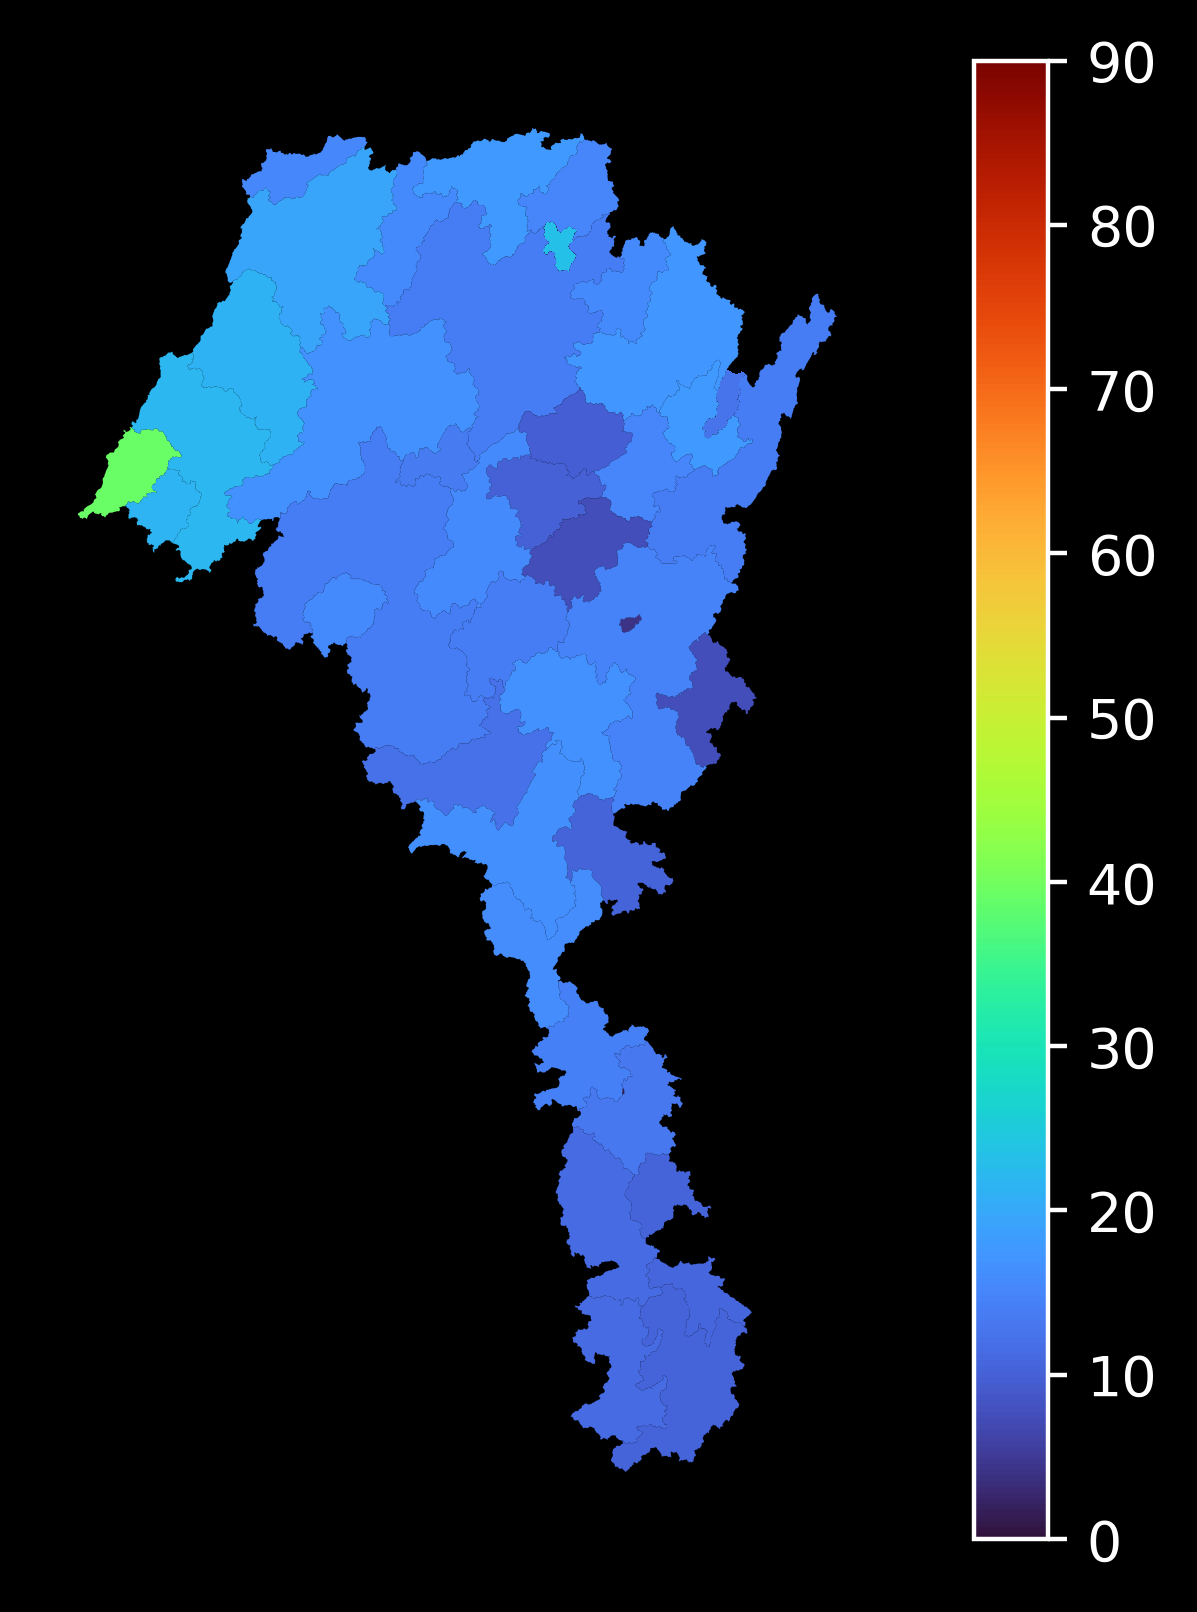

In [86]:
ax=subwatersheds.plot("soil_depth", cmap="turbo", legend=True, vmin=0, vmax=90)
ax.axis('off')

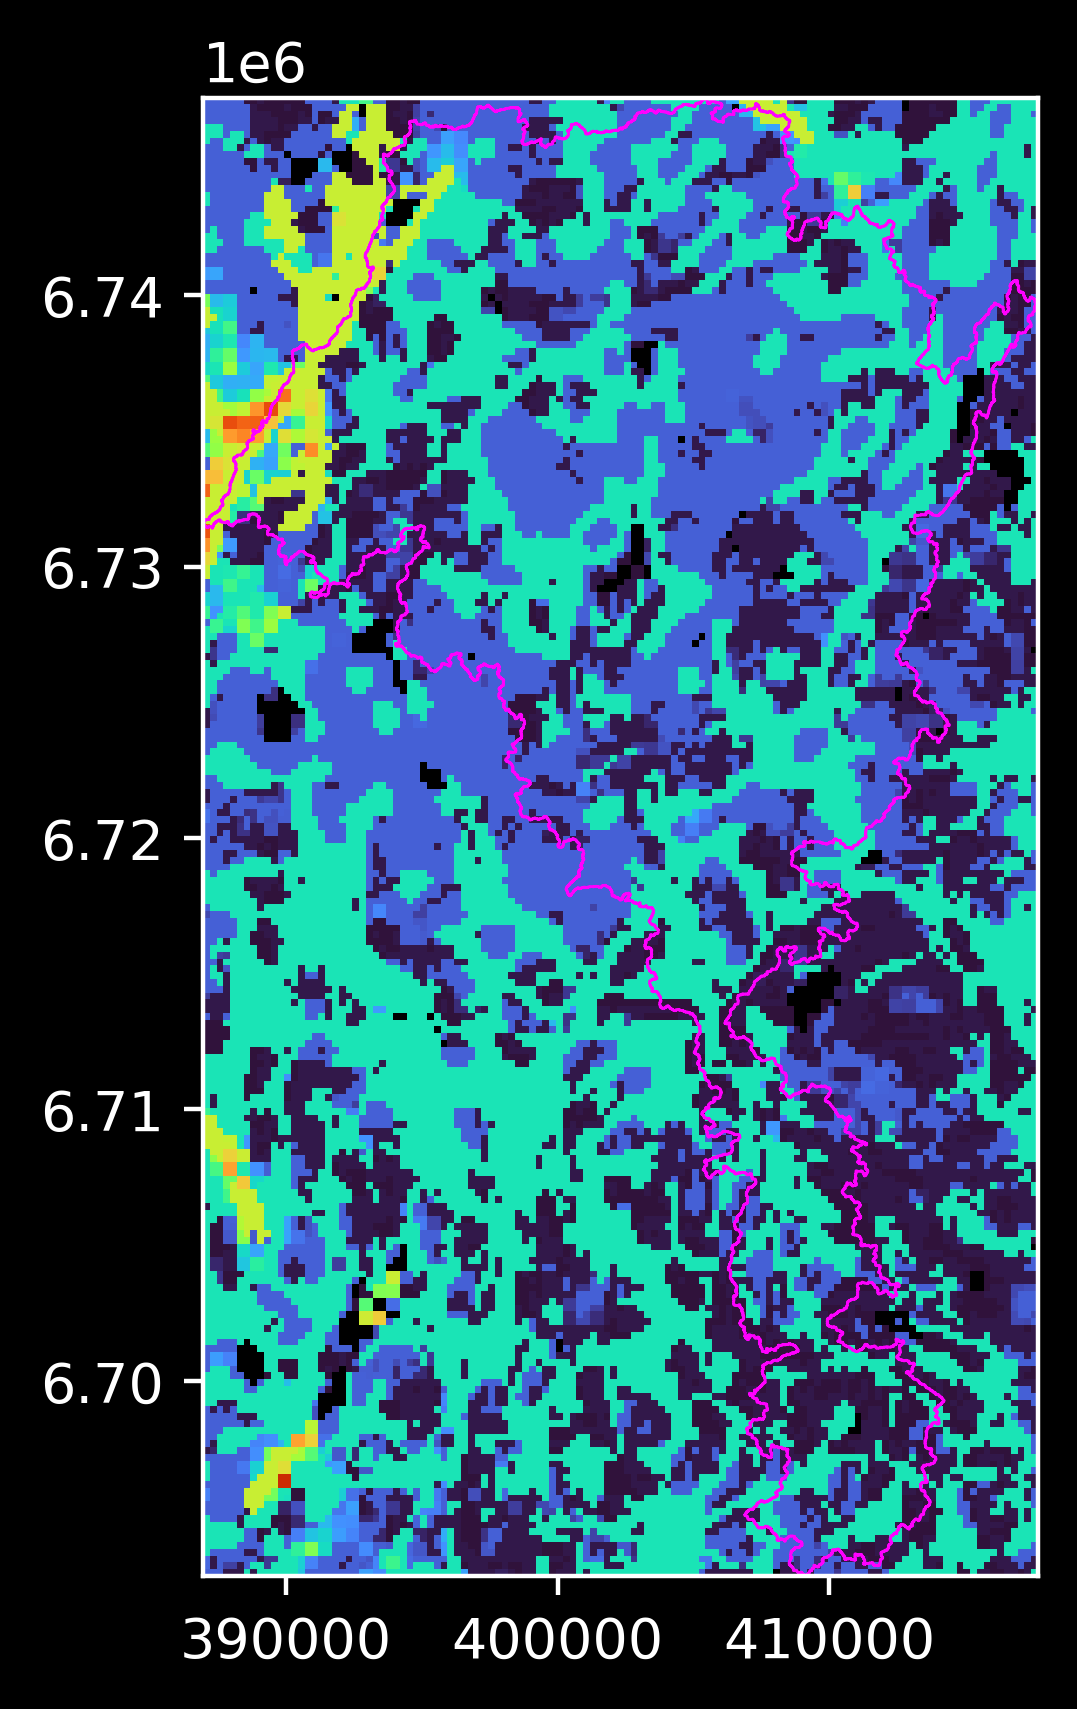

In [87]:
fig, ax = plt.subplots()

show(masked_values, transform=profile['transform'], ax=ax, cmap="turbo", vmin=0, vmax=90)

#show(class_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
#show(clipped_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
ax = watershed.boundary.plot(ax=ax, color='fuchsia', linewidth=0.5)

In [58]:
masked_values.max()

30.0

In [90]:
clipped_values

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-99.0,
  dtype=float32)